Training a TFNO on Darcy-Flow
=============================

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Tensorized Fourier-Neural Operator

In [3]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

Loading the Navier-Stokes dataset in 128x128 resolution

In [4]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        positional_encoding=True
)
data_processor = data_processor.to(device)

Loading test db at resolution 32 with 50 samples and batch-size=32


We create a tensorized FNO model

In [5]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

In [6]:
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 523257 parameters.


In [7]:
test_samples = test_loaders[32].dataset

In [8]:
data = test_samples[0]

In [9]:
data

{'x': tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]),
 'y': tensor([[[1.7661e-04, 3.1267e-03, 4.8439e-03,  ..., 7.7397e-04,
           5.3947e-04, 2.9797e-04],
          [3.1268e-03, 8.3077e-02, 1.3740e-01,  ..., 2.3968e-02,
           1.6445e-02, 8.6891e-03],
          [4.8452e-03, 1.3744e-01, 2.3539e-01,  ..., 4.3717e-02,
           2.9887e-02, 1.5497e-02],
          ...,
          [5.3635e-03, 1.5409e-01, 2.6636e-01,  ..., 4.6299e-02,
           3.2389e-02, 1.6947e-02],
          [4.3675e-03, 1.2199e-01, 2.0668e-01,  ..., 3.2714e-02,
           2.3121e-02, 1.2285e-02],
          [2.8135e-03, 7.3128e-02, 1.1933e-01,  ..., 1.7204e-02,
           1.2349e-02, 6.7479e-03]]])}

In [10]:
data = data_processor.preprocess(data, batched=False)

In [11]:
data

{'x': tensor([[[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0312, 0.0312,  ..., 0.0312, 0.0312, 0.0312],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          ...,
          [0.9062, 0.9062, 0.9062,  ..., 0.9062, 0.9062, 0.9062],
          [0.9375, 0.9375, 0.9375,  ..., 0.9375, 0.9375, 0.9375],
          [0.9688, 0.9688, 0.9688,  ..., 0.9688, 0.9688, 0.9688]],
 
         [[0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.9688],
          [0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.9688],
          [0.0000, 0.0312, 0.0625, 

In [12]:
x = data['x']
y = data['y']

x.shape, y.shape

(torch.Size([3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [13]:
x.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [14]:
out = model(x.unsqueeze(0))
out.shape

torch.Size([1, 1, 32, 32])

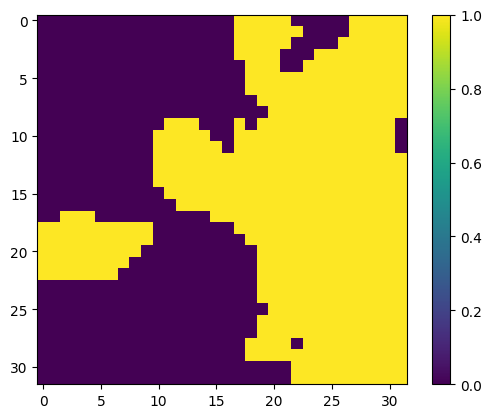

In [18]:
plt.imshow(x[0, :, :])
plt.colorbar()

In [16]:
y.shape

torch.Size([1, 1, 32, 32])

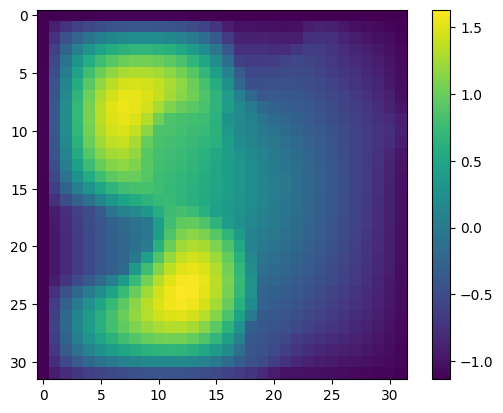

In [19]:
plt.imshow(y.squeeze())
plt.colorbar()

In [20]:
out.shape

torch.Size([1, 1, 32, 32])

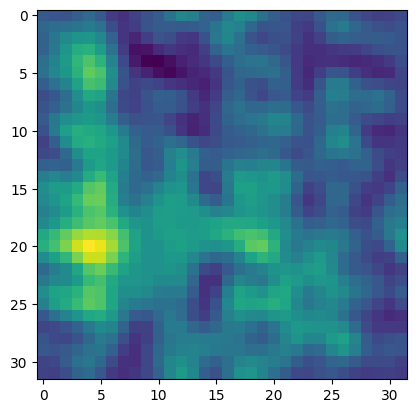

In [21]:
plt.imshow(out.squeeze().detach().numpy())

Create the optimizer

In [22]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses

In [11]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [12]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losse

Create the trainer

In [13]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


Actually train the model on our small Darcy-Flow dataset

In [14]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

{'32_h1': 0.34085957527160643, '32_l2': 0.22883138179779053}

Plot the prediction, and compare with the ground-truth 

Note that we trained on a very small resolution for a very small number of epochs

In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that

i) fits in just a few Mb of memory

ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs

/tmp/ipykernel_122638/1474147971.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


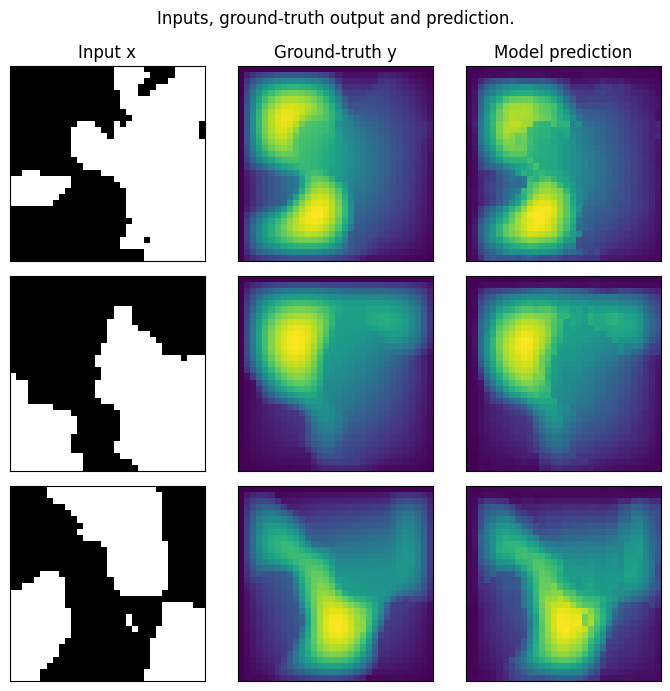

: 

In [15]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()